<a href="https://colab.research.google.com/github/vinay-pv/DA203o_Genre_Classification/blob/main/GenreClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## I. Genre Clustering
In this notebook I explore different clustering algorithms to use on a dataset of music features. Part I involves using all data, while Part II involves using only data from a specific genre.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

import ast
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.cluster import MeanShift, KMeans, AffinityPropagation, AgglomerativeClustering, FeatureAgglomeration, SpectralClustering, estimate_bandwidth
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, v_measure_score
#from sklearn import cluster

### Pre-Processing
Before feeding track data into clustering algorithms, I'll first:
- Absorb genres that have instances that don't meet a certain cutoff, "minor genres", into bigger genres "major genres".  
- Scale the tempo column, which is currently in BPM, to a scale from 0-1.0.


In [ ]:
tracks = pd.read_csv('/content/drive/MyDrive/fma/data/tracks_cleaned.csv', index_col=0)
tracks.drop(['year_released', 'duration', 'artist_id', 'album_id'], axis=1, inplace=True)
audio_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,album,artist,genre_top,genres_all_id,track,genres_all
track_id,,,,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,AWOL - A Way Of Life,AWOL,Hip-Hop,[21],Food,['Hip-Hop']
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,AWOL - A Way Of Life,AWOL,Hip-Hop,[21],Electric Ave,['Hip-Hop']
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,AWOL - A Way Of Life,AWOL,Hip-Hop,[21],This World,['Hip-Hop']
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Constant Hitmaker,Kurt Vile,Pop,[10],Freeway,['Pop']
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,AWOL - A Way Of Life,AWOL,Hip-Hop,[21],Street Music,['Hip-Hop']


#### Distribution of audio features Pre-Normalization

array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>, <Axes: >]], dtype=object)

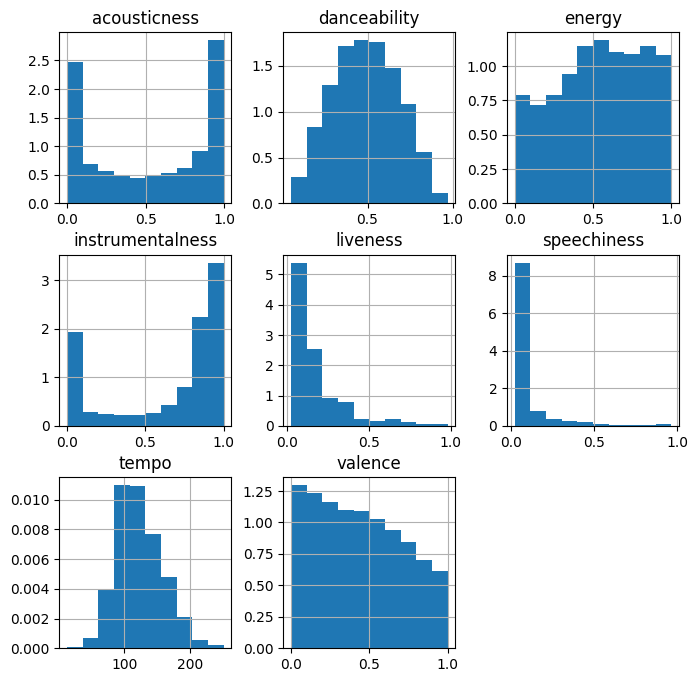

In [ ]:
X_prenorm = tracks[audio_cols]
pd.DataFrame(X_prenorm,columns=audio_cols).hist(figsize=(8,8), density=True)


In [ ]:
genre_count = tracks.groupby('genre_top').agg({'genre_top':'count'})['genre_top']
major_genres = genre_count[genre_count > 300].index.values
minor_genres = genre_count[genre_count <= 300].index.values
print(genre_count)
print("Major genres: {} \nMinor Genres: {}".format(major_genres, minor_genres))

genre_top
Blues                    93
Classical               334
Country                 141
Easy Listening           16
Electronic             3730
Experimental            172
Folk                   1090
Hip-Hop                 995
Instrumental            154
International           216
Jazz                    354
Metal                   374
Old-Time / Historic     373
Pop                     475
Rock                   4467
Soul-RnB                129
Spoken                   16
Name: genre_top, dtype: int64
Major genres: ['Classical' 'Electronic' 'Folk' 'Hip-Hop' 'Jazz' 'Metal'
 'Old-Time / Historic' 'Pop' 'Rock'] 
Minor Genres: ['Blues' 'Country' 'Easy Listening' 'Experimental' 'Instrumental'
 'International' 'Soul-RnB' 'Spoken']


In [ ]:
### method: Merge nearest genres
major_genres = genre_count[genre_count > 300].index.values
minor_genres = genre_count[genre_count <= 300].index.values

# Scale Tempo
tempo = tracks['tempo'].values.reshape(-1,1)
tracks['tempo'] = MinMaxScaler().fit_transform(tempo)

# Normalize audio columns
norm = Normalizer()
tracks[audio_cols] = norm.fit_transform(tracks[audio_cols])

# Group By Mean
genre_groupby = tracks.groupby('genre_top').agg('mean')
clusters = genre_groupby.reset_index().rename({'genre_top':'cluster'}, axis=1)
#clusters['method'] = 'Mean'

minor_clusters = clusters.loc[clusters.cluster.isin(minor_genres)]
major_clusters =  clusters.loc[clusters.cluster.isin(major_genres)]

new_genres = dict(zip(major_genres,major_genres))

for i, r in minor_clusters.iterrows():
    genre = r[0]
    genre_coordinates = r[1:9].values
    genre_coordinates_other = major_clusters[audio_cols].values

    # Calculate distances between each genre; choose closest genre as the one with minimum distance
    distances = [abs(np.linalg.norm(genre_coordinates-c)) for c in genre_coordinates_other]
    min_distance = min(distances)
    closest_genre = major_genres[distances.index(min_distance)]
    print("minor genre: {}, closest major genre: {}".format(genre, closest_genre))

    # Reassign genre values for largely minority genres
    tracks['genre_top'].loc[tracks['genre_top']==genre] = closest_genre
    new_genres[closest_genre] = new_genres[closest_genre] + "/" + genre

tracks = tracks.replace(new_genres)
print(tracks.groupby('genre_top').agg({'genre_top':'count'})['genre_top'])

minor genre: Blues, closest major genre: Folk
minor genre: Country, closest major genre: Pop
minor genre: Easy Listening, closest major genre: Hip-Hop
minor genre: Experimental, closest major genre: Jazz
minor genre: Instrumental, closest major genre: Rock
minor genre: International, closest major genre: Jazz
minor genre: Soul-RnB, closest major genre: Rock
minor genre: Spoken, closest major genre: Old-Time / Historic
genre_top
Classical                           334
Electronic                         3730
Folk/Blues                         1183
Hip-Hop/Easy Listening             1011
Jazz/Experimental/International     742
Metal                               374
Old-Time / Historic/Spoken          389
Pop/Country                         616
Rock/Instrumental/Soul-RnB         4750
Name: genre_top, dtype: int64


<ipython-input-11-a5ca7397c0d9>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_groupby = tracks.groupby('genre_top').agg('mean')
<ipython-input-11-a5ca7397c0d9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['genre_top'].loc[tracks['genre_top']==genre] = closest_genre
<ipython-input-11-a5ca7397c0d9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks['genre_top'].loc[tracks['genre_top']==genre] = closest_g

In [ ]:
genre_groupby = tracks.groupby('genre_top').agg('mean')
clusters = genre_groupby.reset_index().rename({'genre_top':'cluster'}, axis=1)
clusters['method'] = 'Mean'

clusters

<ipython-input-12-539ea15e2ce4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre_groupby = tracks.groupby('genre_top').agg('mean')


,cluster,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,method
0,Classical,0.685280,0.218527,0.059908,0.501577,0.152654,0.035869,0.260014,0.160704,Mean
1,Electronic,0.231575,0.395585,0.407396,0.480360,0.117085,0.076893,0.318820,0.285031,Mean
2,Folk/Blues,0.567995,0.310438,0.211877,0.435505,0.113401,0.043372,0.303129,0.242269,Mean
3,Hip-Hop/Easy Listening,0.276851,0.437786,0.396133,0.248865,0.132440,0.165026,0.309736,0.404069,Mean
4,Jazz/Experimental/International,0.530045,0.303898,0.241823,0.427965,0.139671,0.070398,0.294691,0.282844,Mean
5,Metal,0.205372,0.300066,0.500292,0.474909,0.131244,0.056292,0.342583,0.221618,Mean
6,Old-Time / Historic/Spoken,0.605807,0.262476,0.101372,0.442455,0.236244,0.098264,0.256528,0.315381,Mean
7,Pop/Country,0.401716,0.396639,0.330531,0.309272,0.116587,0.051965,0.340325,0.341957,Mean
8,Rock/Instrumental/Soul-RnB,0.340883,0.291912,0.430487,0.424062,0.131278,0.046717,0.337351,0.299981,Mean


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>, <Axes: >]], dtype=object)

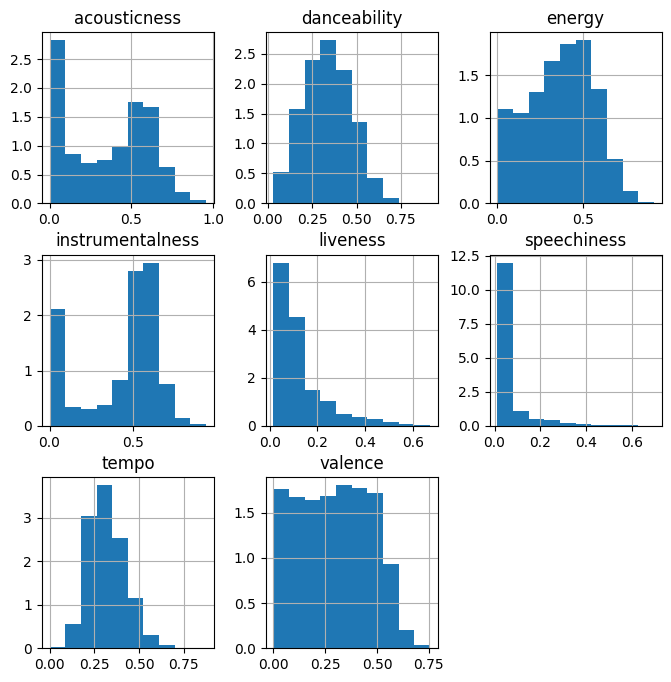

In [ ]:
tracks[audio_cols].hist(figsize=(8,8), density=True)

### Clustering on all genres: Preliminary Machine Learning

### Finding appropriate K-Values
#### Elbow Method

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(0.5, 1.0, 'Elbow Method')

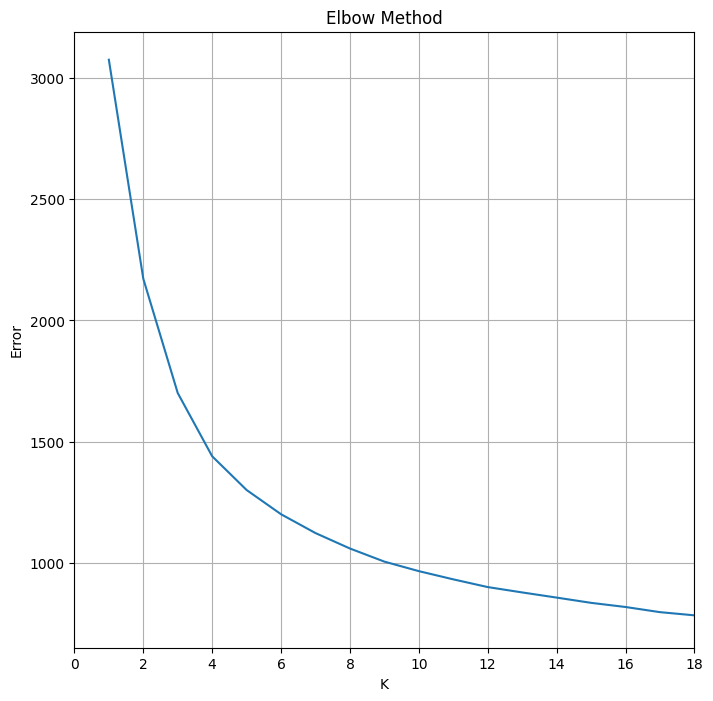

In [ ]:
X = tracks[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']]

Ks = np.arange(1, 20)
km = [KMeans(n_clusters=i, random_state=1986) for i in Ks]
score = [-km[i].fit(X).score(X) for i in range(len(km))]
Ks.dtype = int
plt.figure(figsize=(8,8))
plt.plot(Ks,score)
plt.xlim(0,18)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Elbow Method')

#### Silhouette Scores

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(0.5, 0, 'K')

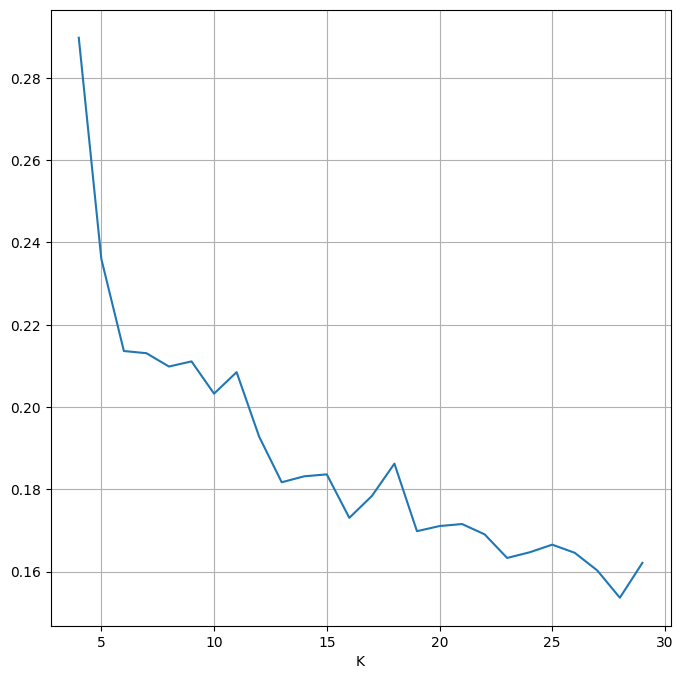

In [ ]:
Ks = np.arange(2, 30)
kms = [KMeans(n_clusters=i, random_state=1986).fit(X) for i in Ks]
s_scores = [silhouette_score(X,kms[i].labels_) for i in range(2,len(Ks))]
plt.figure(figsize=(8,8))
plt.plot(Ks[2:len(Ks)],s_scores)
#plt.xlim(0,18)
plt.grid(True)
plt.xlabel('K')
            

#### K-Means With K = number of unique genres

The first insight to uncover is whether K-Means can detect clusters similar to that of the pre-defined genres. 

In [ ]:
X = tracks[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']]

km = KMeans(n_clusters=len(major_genres), n_init=10, random_state=1986)
km.fit(X)
labels = km.labels_
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
km_clusters = pd.DataFrame(cluster_centers, columns=audio_cols)
km_clusters['cluster'] = ['KM{}'.format(l) for l in labels_unique]
km_clusters['method'] = 'KMeans'
clusters = pd.concat([clusters, km_clusters])
cols = ['cluster'] + audio_cols + ['method']
clusters = clusters[cols]

In [ ]:
clusters

,cluster,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,method
0,Classical,0.685280,0.218527,0.059908,0.501577,0.152654,0.035869,0.260014,0.160704,Mean
1,Electronic,0.231575,0.395585,0.407396,0.480360,0.117085,0.076893,0.318820,0.285031,Mean
2,Folk/Blues,0.567995,0.310438,0.211877,0.435505,0.113401,0.043372,0.303129,0.242269,Mean
3,Hip-Hop/Easy Listening,0.276851,0.437786,0.396133,0.248865,0.132440,0.165026,0.309736,0.404069,Mean
4,Jazz/Experimental/International,0.530045,0.303898,0.241823,0.427965,0.139671,0.070398,0.294691,0.282844,Mean
5,Metal,0.205372,0.300066,0.500292,0.474909,0.131244,0.056292,0.342583,0.221618,Mean
6,Old-Time / Historic/Spoken,0.605807,0.262476,0.101372,0.442455,0.236244,0.098264,0.256528,0.315381,Mean
7,Pop/Country,0.401716,0.396639,0.330531,0.309272,0.116587,0.051965,0.340325,0.341957,Mean
8,Rock/Instrumental/Soul-RnB,0.340883,0.291912,0.430487,0.424062,0.131278,0.046717,0.337351,0.299981,Mean
0,KM0,0.097924,0.403093,0.434742,0.512569,0.101359,0.056072,0.305239,0.457836,KMeans


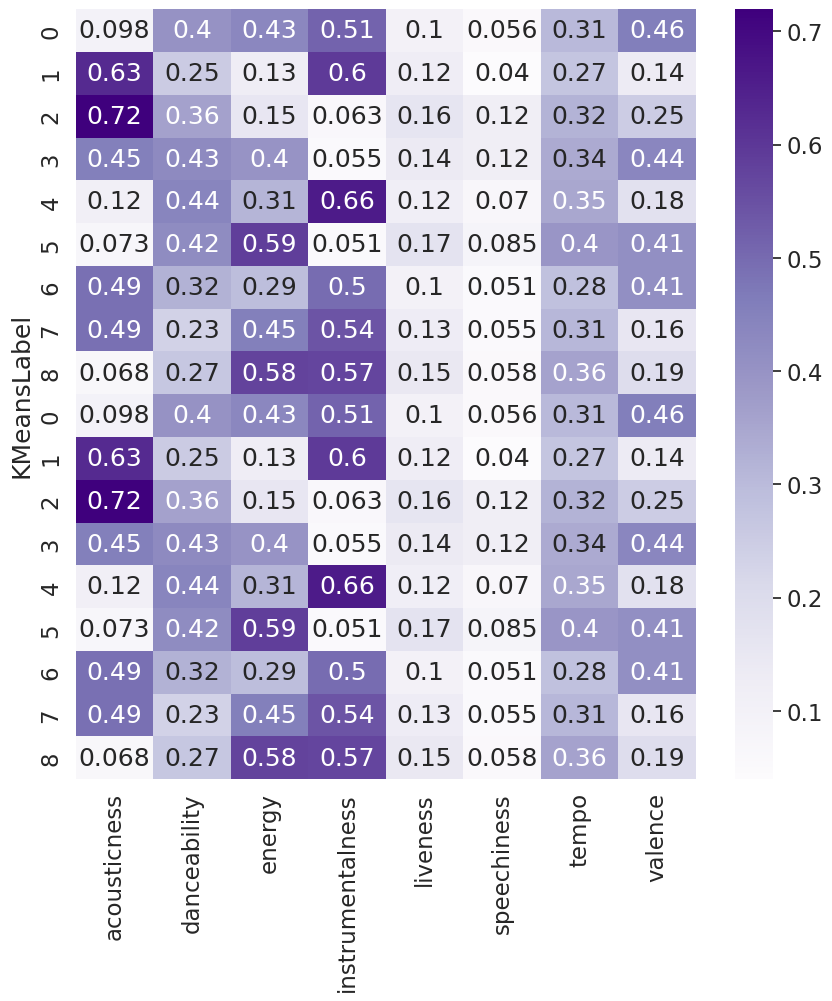

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.heatmap(
    data=clusters.loc[clusters.method=='KMeans', audio_cols],
    cmap='Purples',
    annot=True
)
plt.ylabel("KMeansLabel")
plt.savefig('heatmap_all.png')

#### What do these clusters mean???
One of the main purposes of this project is to see if clustering provides any sort of meaning behind any existing structure within the data. Given the cluster centroids from K-means, we can see the values which characterize each K-Means Label. From eyeballing the values and heatmap, I can describe these clusters based on the meaning behind each feature. In quotes are best-guess interpretations for these genres, meant to resemble Netflix's disturbingly specific genres. Someone with a wider music vocabulary can easily think up of better genre names. For more on the meaning behind each feature, see [Spotify's API](https://developer.spotify.com/web-api/get-audio-features/) 
- **KM0**: Highly acoustic and instrumental. Low danceability, energy tempo, valence. "Slow & Somber Acoustics"
- **KM1**: Highly instrumental and valent. Mid-tempo, mid-energy. Low acousticness and speechiness. "Happy & Danceable Instrumentals"
- **KM2**: Highly instrumental. Mid acousticness. Low valence, speechiness. "Sad Instrumentals"
- **KM3**: Highly valent. Speechy. Mid-instrumental, mid-energy. Low instrumentalness. "Upbeat Songs With Cheerful Vocals"
- **KM4**: Highly instrumental, danceable, fast. Mid-energy. Low acousticness. "Fast & Danceable Instrumentals". 
- **KM5**: High energy, valent, and fast. Relatively high liveness. Low acousticness and instrumentalness. 'Fast, Upbeat & Cheerful"
- **KM6**: Highly acoustic. Mid-high danceable. Speechy. Low energy. "Slow Dance".
- **KM7**: Highly valent and instrumental. Low tempo and speechiness. "Happy & Slow"
- **KM8**: High energy, tempo and instrumentalness. Low acousticness and speechiness. "Happy & Upbeat Instrumentals"


Moreover, we can see how these clusters relate to each genre below. 

In [ ]:
#distances = [abs(np.linalg.norm(genre_coordinates-c)) for c in genre_coordinates_other]
### Assign K-Means Label to Descriptive Labels
descriptive_labels = ["Slow & Somber Acoustics", "Happy & Danceable Instrumentals", "Sad Instrumentals", 
                     "Upbeat Songs With Cheerful Vocals", "Fast & Danceable Instrumentals", "Fast, Upbeat & Cheerful Songs",
                     "Slow Dance", "Happy & Slow", "Happy & Upbeat Instrumentals"]
unique_labels = np.unique(labels)
translated_labels = dict(zip(unique_labels, descriptive_labels))
tracks['KMeansLabel'] = list(map(lambda x:translated_labels[x], labels))

genre_count = tracks.groupby('genre_top').agg({'genre_top':'count'})['genre_top']

# How many instances of each k-means cluster are there?
print("### Instances of KMeans Cluster ###")
print(tracks[['genre_top', 'KMeansLabel']].groupby('KMeansLabel').agg('count'))

# Which cluster corresponds to the most instances per genre?
print("### Which cluster corresponds to the most instances per genre? ###")
print(tracks[['genre_top', 'KMeansLabel']].groupby('genre_top').agg(lambda x:x.value_counts().index[0]))

# Which genre corresponds to the most instances per cluster?
print("### Which genre corresponds to the most instances per cluster? ###")
print(tracks[['genre_top', 'KMeansLabel']].groupby('KMeansLabel').agg(lambda x:x.value_counts().index[0]))

### Instances of KMeans Cluster ###
                                   genre_top
KMeansLabel                                 
Fast & Danceable Instrumentals          1051
Fast, Upbeat & Cheerful Songs           1369
Happy & Danceable Instrumentals         1988
Happy & Slow                            1559
Happy & Upbeat Instrumentals            1453
Sad Instrumentals                        899
Slow & Somber Acoustics                 1730
Slow Dance                              1929
Upbeat Songs With Cheerful Vocals       1151
### Which cluster corresponds to the most instances per genre? ###
                                                       KMeansLabel
genre_top                                                         
Classical                          Happy & Danceable Instrumentals
Electronic                                 Slow & Somber Acoustics
Folk/Blues                         Happy & Danceable Instrumentals
Hip-Hop/Easy Listening           Upbeat Songs With Cheerful Vocals


There are some interesting conclusions that match up with everyday musical intuition. 

In cell 2, The most predominant KMeans Label for Classical, Folk/Blues, and Jazz are Slow & Somber Acoustics. In contrast, the most predominant KMeans Label for Electronic, Pop, and Country are Upbeat Songs With Cheerful Songs, which make sense. Metal's most predominant KMeans Label is Happy & Upbeat Instrumentals, which may indicate an unfortunately high amount of power metal in our sample. 

In cell 3, we see Rock/Instrumental/Soul-RnB dominate 4 out of 5 "Happy/Cheerful" KMeans Labels. Folk/Blues, which tends to be slower, does end up categorized as typically slow. 

#### Evaluating K-Means with different metrics
Because clustering can be highly subjective, it's difficult to gauge the accuracy of the model. One approach is to plot them visually and manually differentiate between each cluster, which is done later. Another approach is by calculating various metrics, as down below. The mathematical formulation can be found in sklearn's (clustering evaluation)[http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation] section. Here are ways to interpret the scores:
- **Adjusted Rand Score**: Bounded [-1,1] where 1 represents perfect label, and a score near or below 0 have independent, or "bad" labelings. 
- **Adjusted Mutual Info Score**: Bounded [0,1] where 1 represents perfect label, and a score nea0 have independent, or "bad" labelings
- **V Measure Score**: Bounded [0,1] scores: 0.0 is as bad as it can be, 1.0 is a perfect score.
- **Silhouette Score**: The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

In [ ]:
# y_true = tracks['genre_top']
# y_pred = tracks['KMeansLabel']
# metrics = {'adjusted_rand_score':adjusted_rand_score, 
#            'adjusted_mutual_info_score':adjusted_mutual_info_score, 
#            'v_measure_score':v_measure_score
#           }
# scores = dict(zip(metrics.keys(), [metrics[m](y_true, y_pred) for m in metrics.keys()]))
# scores['silhouette_score'] = silhouette_score(X,y_pred)
# for k,v in scores.items():
#     print("Metric: {} Score: {}".format(k, v))

When comparing the K-Means Labels with the actual genres, the clustering model performed poorly. All metrics scored the model close to zero, and could not detect structure within the data.

#### Evaluating K-Means Visually
X has n_features = n_dimensions = 8, the clustering model can't be plotted as is. Before plugging everything into seaborn, we perform PCA through FeatureAgglomeration in order to reduce the dimensions from 8 to 2. This process effectively takes related features and merges them into different axes. 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
x,y = zip(*X_new)
tracks['x'] = x
tracks['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

In [ ]:
audio_components = dict(list(zip(audio_cols, zip(*np.round(components,2)))))
audio_components


{'acousticness': (0.77, -0.35),
 'danceability': (-0.16, -0.16),
 'energy': (-0.5, 0.07),
 'instrumentalness': (0.24, 0.86),
 'liveness': (-0.02, -0.04),
 'speechiness': (-0.03, -0.09),
 'tempo': (-0.11, -0.02),
 'valence': (-0.26, -0.29)}

In [ ]:
components

array([[ 0.76921521, -0.16251451, -0.49882612,  0.23535638, -0.01715574,
        -0.02564273, -0.10626609, -0.25579783],
       [-0.35482308, -0.1564858 ,  0.07388942,  0.8636447 , -0.04443051,
        -0.09467522, -0.02415382, -0.29453368]])

In [ ]:
singular_values

array([34.62226634, 29.55900906])

Text(0.5, 1.0, 'Clustering by Genre, Reduced Dimension')

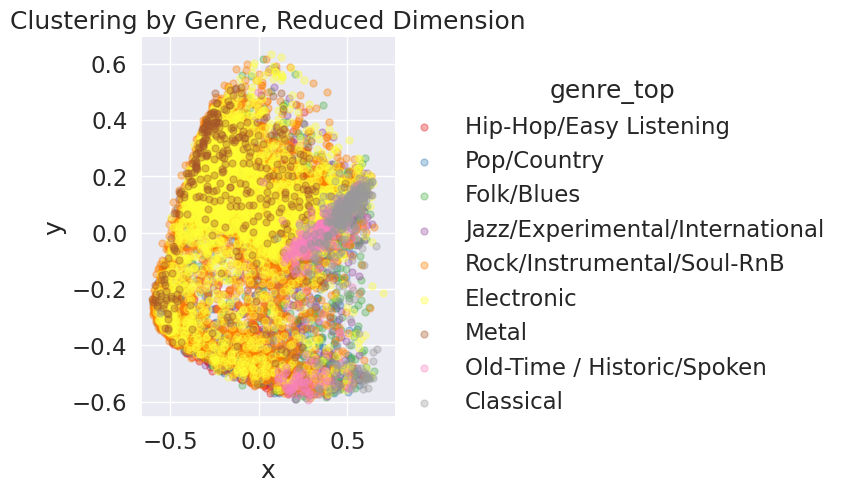

In [ ]:
sns.set(font_scale=1.5)
sns.lmplot(data=tracks, x='x', y='y', hue='genre_top', fit_reg=False, legend=True,  palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
# plt.legend(loc='lower right')
# plt.ylim(-0.7,1.8)
# plt.xlim(-0.7,1.8)
plt.savefig('pca_scatter_genres.png')
plt.title("Clustering by Genre, Reduced Dimension")
# arrow = plt.arrow(x=0.2, y=-0.40, dx=0.4, dy=0, width=0.04, label='More acoustic, less energy')
# arrow.label = 'More acoustic, less energy'

The dataset tends to be relatively unstructured by genre, save for a few clusters. This explains why our metrics performed poorly. There are some visual groupings, such as classical music being close to one another, and electronic music being grouped from y=0-0.15 and x=0.3-0.4. 

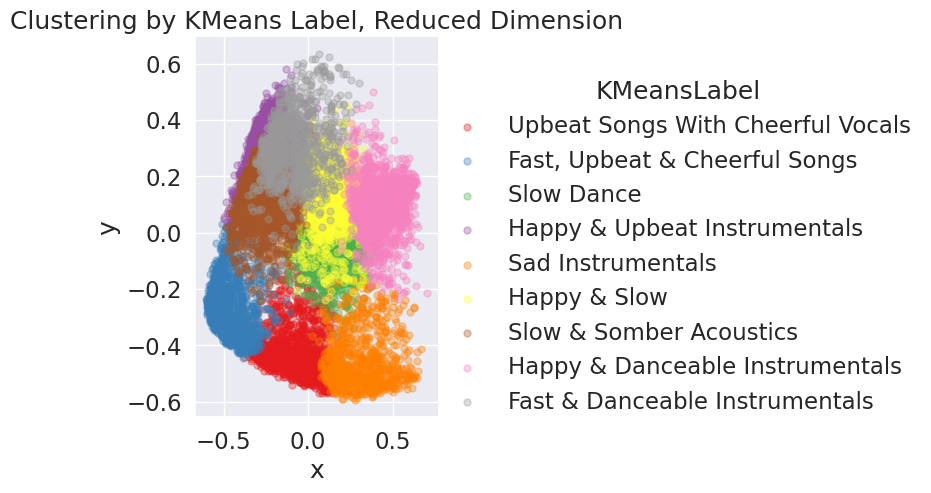

In [ ]:
sns.set(font_scale=1.5)

sns.lmplot(data=tracks, x='x', y='y', hue='KMeansLabel', fit_reg=False, legend=True,  palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.title("Clustering by KMeans Label, Reduced Dimension")

plt.savefig('pca_scatter_KM.png')

In [ ]:
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,album,artist,genre_top,genres_all_id,track,genres_all,KMeansLabel,x,y
track_id,,,,,,,,,,,,,,,,,
2,0.307539,0.498863,0.468293,0.007844,0.131117,0.117583,0.474367,0.425621,AWOL - A Way Of Life,AWOL,Hip-Hop/Easy Listening,[21],Food,['Hip-Hop'],Upbeat Songs With Cheerful Vocals,-0.259500,-0.411041
3,0.294663,0.416047,0.643350,0.001457,0.083329,0.363455,0.377140,0.211895,AWOL - A Way Of Life,AWOL,Hip-Hop/Easy Listening,[21],Electric Ave,['Hip-Hop'],"Fast, Upbeat & Cheerful Songs",-0.285254,-0.341951
5,0.033163,0.567520,0.533955,0.000530,0.284035,0.094841,0.279499,0.473205,AWOL - A Way Of Life,AWOL,Hip-Hop/Easy Listening,[21],This World,['Hip-Hop'],"Fast, Upbeat & Cheerful Songs",-0.509691,-0.339844
10,0.462145,0.319621,0.448963,0.468825,0.056076,0.016018,0.201340,0.467933,Constant Hitmaker,Kurt Vile,Pop/Country,[10],Freeway,['Pop'],Slow Dance,0.028774,-0.034072
134,0.315940,0.358572,0.391528,0.013584,0.067466,0.367152,0.297662,0.624640,AWOL - A Way Of Life,AWOL,Hip-Hop/Easy Listening,[21],Street Music,['Hip-Hop'],Upbeat Songs With Cheerful Vocals,-0.228034,-0.467933


In [ ]:
tracks.rename({'genre_top':'MainGenre'}, axis=1).to_csv('tracks_with_kmeans.csv')
#tracks.

When giving K-Means free reign, more distinct groupings are shown and the clusters make more sense. 

## II: Clustering Rock Tracks
In this section, I take a subset of the tracks data, the tracks with a top genre labeled as "Rock", and perform clustering on the subgenres within rock. I'll follow similar steps as above, but this time I'll also incorporate clustering algorithms which don't require the n_clusters parameter beforehand. 

### Pre-processing

1. The first step is to re-initialize the tracks dataframe and extract the tracks that have genre = 'Rock'. We don't want to just use the rock tracks from the above dataframe because:
    1. The features from `tracks` are normalized with other non-rock genres and 
    2. Some genres outside of rock were merged into Rock (i.e. 'Rock' is absorbed as 'Rock/Soul-RnB/Instrumental' - we want just Rock here). 
2. The brand new reinitialized dataframe is called `rock_tracks`

3. Find the top $k$ subgenres within rock, denoted by the subgenres with the $k$ most instances. This is the variable `top_subgenres_list`. For this model, I chose $k$=5 because anything below that for this dataset will show up <10% of the time. 

4. `rock_tracks` is then scaled and normalized.

5. A subgenre from `top_subgenres_list` is assigned to each track based on the "genres_all" column of `rock_tracks` and placed in the "subgenre" column. Each track may contain many or no subgenre values within genres_all. If there's no subgenre values within "genres_all" inside `top_subgenres_list`, then the "subgenre" column is assigned to be "Rock". Else, a subgenre element from "genres_all" that's in `top_subgenres_list` is assigned to the "subgenre" column.

In [ ]:
### Reinitialize tracks data

rock_tracks = pd.read_csv('/content/drive/MyDrive/fma/data/tracks_cleaned.csv', index_col=0)
rock_tracks.drop(['year_released', 'duration', 'artist_id', 'album_id'], axis=1, inplace=True)

### Accumulate rock and metal tracks. Metal, while its own distinct genre, shares many similar features to rock
rock_tracks.loc[rock_tracks['genre_top']=='Metal','genre_top'] = 'Rock'
rock_tracks = rock_tracks.loc[rock_tracks['genre_top']=='Rock', audio_cols + ['genres_all']]

### Turn rock_tracks 'genres_all' column into list type
rock_tracks['genres_all'] = np.array(list(map(ast.literal_eval,rock_tracks['genres_all'])))

rock_tracks.head()

<ipython-input-35-32daf12c324d>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rock_tracks['genres_all'] = np.array(list(map(ast.literal_eval,rock_tracks['genres_all'])))


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genres_all
track_id,,,,,,,,,
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,"[Post-Rock, Rock]"
154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632,"[Post-Rock, Rock]"
155,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325,"[Post-Rock, Rock]"
169,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347,"[Punk, Rock]"
170,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548,"[Punk, Rock]"


In [ ]:
rock_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4841 entries, 153 to 124186
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      4841 non-null   float64
 1   danceability      4841 non-null   float64
 2   energy            4841 non-null   float64
 3   instrumentalness  4841 non-null   float64
 4   liveness          4841 non-null   float64
 5   speechiness       4841 non-null   float64
 6   tempo             4841 non-null   float64
 7   valence           4841 non-null   float64
 8   genres_all        4841 non-null   object 
dtypes: float64(8), object(1)
memory usage: 378.2+ KB


array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>, <Axes: >]], dtype=object)

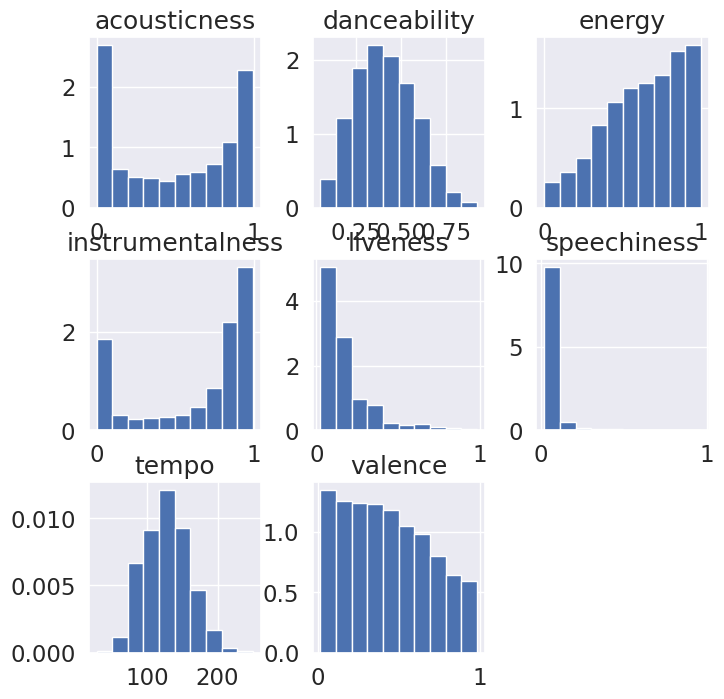

In [ ]:
### Pre-norm distribution

rock_tracks[audio_cols].hist(figsize=(8,8), density=True)

array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>, <Axes: >]], dtype=object)

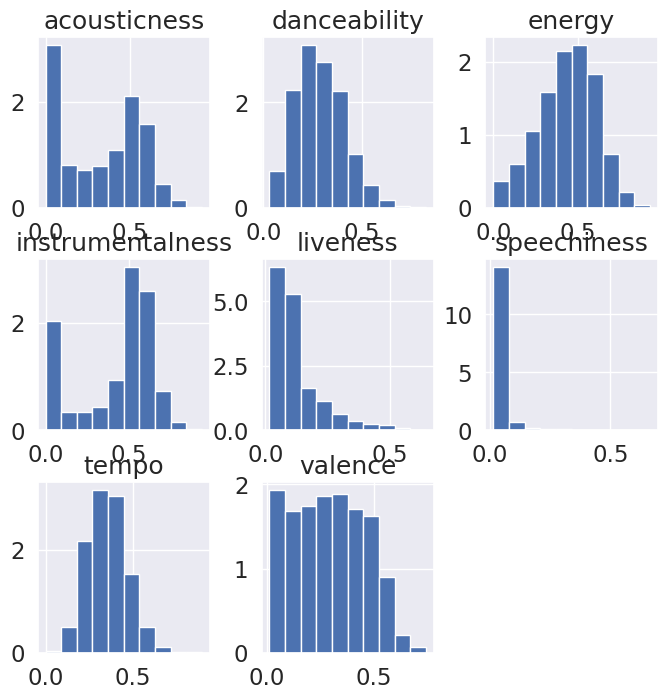

In [ ]:
# Scale Tempo
tempo = rock_tracks['tempo'].values.reshape(-1,1)
rock_tracks['tempo'] = MinMaxScaler().fit_transform(tempo)

# Normalize audio columns
norm = Normalizer()
rock_tracks[audio_cols] = norm.fit_transform(rock_tracks[audio_cols])

rock_tracks[audio_cols].hist(figsize=(8,8), density=True)

In [ ]:
def count_genres(genres_list, genres_dict):
    '''
    Given a list of genre values genres_list from a column value, count instances of each genre and store in dictionary genres_dict.
    Simply using column.value_counts() doesn't work because each element in a column is a list. 
    '''
    
    for genre in genres_list:
        if genre in genres_dict:
            genres_dict[genre] += 1
        else:
            genres_dict[genre] = 1
    return genres_list

def assign_subgenre(subgenres_list, top_subgenres, default='Rock'):
    '''
    Takes in a list of subgenres from a column value subgenres_list, and iterates through that list to check if that subgenre
    is in top_subgenres. If it is, the value from top_subgenres that matches the value from subgenres_list is returned.
    This is used to assign a specific subgenre given that a track contains many subgenres. 
    '''
    if len(subgenres_list) > 1:
        for subgenre in subgenres_list:
            if (subgenre in top_subgenres) and (subgenre != default):
                return subgenre
        return default
    else:
        return default

### Accumulate top subgenres
genres_dict = {}
rock_tracks['genres_all'].apply(lambda row:count_genres(row,genres_dict))
k=5
genres_by_count = pd.Series(genres_dict).sort_values(ascending=False)
print("Top 10 instances of subgenres within rock tracks")
print(genres_by_count[:10])

# Starting at 1 to exclude "Rock", which is a main genre and applies to all rock tracks
top_subgenres = genres_by_count[1:k]
top_subgenres_list = list(top_subgenres.index.values)

### Assign subgenres for those containing more than one genre
rock_tracks['subgenre'] = list(map(lambda row: assign_subgenre(row, top_subgenres_list, "Rock"), rock_tracks['genres_all']))
print("Rock tracks reduced to a top {} subgenre".format(k))
print(rock_tracks['subgenre'].value_counts())

Top 10 instances of subgenres within rock tracks
Rock          4798
Punk          1551
Indie-Rock    1011
Psych-Rock     542
Pop            533
Post-Punk      382
Metal          256
Post-Rock      209
Hardcore       208
Power-Pop      199
dtype: int64
Rock tracks reduced to a top 5 subgenre
Rock          1790
Punk          1474
Indie-Rock     730
Psych-Rock     447
Pop            400
Name: subgenre, dtype: int64


In [ ]:
rock_tracks.sample(10)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genres_all,subgenre
track_id,,,,,,,,,,
87309,0.006662,0.219678,0.513468,0.524391,0.162916,0.021503,0.350903,0.512762,[Rock],Rock
39965,0.463029,0.258130,0.343814,0.667585,0.077728,0.030782,0.311550,0.225928,"[Psych-Rock, Rock, Shoegaze]",Psych-Rock
1125,0.569478,0.265552,0.236604,0.478820,0.137539,0.167711,0.407707,0.326586,[Rock],Rock
19659,0.503870,0.263206,0.344836,0.629478,0.168231,0.024124,0.295468,0.213303,"[Punk, Rock, No Wave]",Punk
845,0.263395,0.377012,0.613232,0.139208,0.123816,0.038258,0.584621,0.185678,[Rock],Rock
82911,0.000331,0.402491,0.570306,0.201440,0.060980,0.021621,0.372623,0.573707,"[Indie-Rock, Rock]",Indie-Rock
12610,0.299555,0.131715,0.413443,0.059806,0.090497,0.032513,0.757883,0.367114,"[Rock, Metal]",Rock
34423,0.545949,0.208549,0.278712,0.561416,0.064966,0.017520,0.365409,0.357111,"[Psych-Rock, Rock]",Psych-Rock
108482,0.019001,0.358193,0.618561,0.006194,0.112991,0.038923,0.588762,0.357434,"[Pop, Rock, Metal]",Pop


### Clustering

The following section is the application of select clustering algorithms on the rock_tracks data. Information on these algorithms can be found on [sklearn's clustering section](http://scikit-learn.org/stable/modules/clustering.html). Briefly, here are the algorithms used and why I chose them:
- **K-Means (K = 5)**: K-Means where K is the number of expected subgenres ideally should yield clusters resemble the subgenres themselves, **assuming that the data is structured in some way**. This is the key assumption that determines how well clustering performs in general. This is the baseline I'll use when comparing different clustering algorithms.
- **MeanShift**: Good for uneven cluster sizes, which we may expect due to the distribution of subgenres. 
- **WardHierarchical/AgglomerativeClustering**: Uses tree representations of data to separate them into clusters. Given the complex nature of music this is an interesting approach to clustering this dataset. Could find many clusters.  n_clusters is a required parameter.
- **SpectralClustering**: Could find few clusters with roughly even size. Starkly contrasts usecase for MeanShift. 


In [ ]:
X = rock_tracks[audio_cols]
y_true = rock_tracks.subgenre


In [ ]:
### Finding best parameters for meanshift

### WARNING: this cell takes a few minutes to run due to the computationally expensive nature of MeanShift.
### This cell can be skipped as the optimal quantile was found to be 0.14

# from sklearn.cluster import estimate_bandwidth
# quantiles = np.arange(0.1,0.21,0.02)
# quantiles_dict = {}
# df_meanshift = pd.DataFrame(columns=['Quantile{}'.format(round(quantile),2) for quantile in quantiles])
# for quantile in quantiles:
#     bandwidth = estimate_bandwidth(X,quantile=quantile)
#     ms = MeanShift(bandwidth=bandwidth)
#     ms.fit(X)
#     cluster_centers = ms.cluster_centers_
#     labels = ms.labels_
#     labels_unique = np.unique(labels)
#     n_clusters_ = np.unique(len(labels_unique))
#     quantiles_dict[quantile] = bandwidth
#     print("Estimating Bandwidth with quantile = {}".format(quantile))
#     print("N Clusters = ", n_clusters_)
#     df_meanshift['Quantile{}'.format(round(quantile,2))] = pd.Series(labels)
#     print(pd.Series(labels).value_counts())
    
# df_meanshift.hist(figsize=(5,10), sharex=True, bins=6)

It's subjective which bandwidth is optimal. Having a bandwidth with quantile too high reduces n_clusters to a meaningless value. Having a bandwidth with quantile too low creates a few fringe clusters that can be attributed to noise. To reasonably minimize both concerns, I set the bandwidth quantile equal to ~0.14.

In [ ]:
### Running Affinity Propagation was ineffective. Here's my implementation with various parameters. 

# dampings = np.arange(0.5,0.95,0.05)
# df_ap = pd.DataFrame()
# for damping in dampings:
#     ap = AffinityPropagation(damping=damping)
#     ap.fit(X)
#     ap_labels = ap.labels_
#     print("Damping: {}, Clusters: {}".format(damping, len(np.unique(ap_labels)))
#     df_ap['Damping{}'.format(round(damping),3)] = ap_labels
    
# df_ap.hist(figsize=(10,10), density=True)

In [ ]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
import warnings


subgenre_groupby = rock_tracks.copy().groupby('subgenre').agg('mean')
clusters_rock = subgenre_groupby.reset_index().rename({'subgenre':'cluster'}, axis=1)
clusters_rock['method'] = 'AggMean'


# plt.figure(figsize=(9 * 2 + 3, 12.5))
# plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
#                     hspace=.01)

plot_num = 1

params = {'quantile': .14,
        'n_clusters': k
}
params['bandwidth'] = estimate_bandwidth(X,quantile=params['quantile'])
# ============
# Create cluster objects
# ============
km = KMeans(n_clusters=params['n_clusters'], random_state=1986)
ms = MeanShift(bandwidth=params['bandwidth'])
ward = AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
)
spectral_known = SpectralClustering(
    n_clusters=params['n_clusters'], 
    affinity="nearest_neighbors")
spectral_unknown = SpectralClustering(
    affinity="nearest_neighbors")
# affinity_propagation = AffinityPropagation(
#     damping=params['damping'], preference=params['preference'])


clustering_algorithms = (
    ('KMeans', km),
#     ('AffinityPropagation', affinity_propagation),
    ('SpectralClusteringKnown', spectral_known),
    ('SpectralClusteringUnknown', spectral_unknown),
    ('MeanShift', ms),
    ('Ward', ward),
)
clustering_algorithm_names = ['KMeans', 'SpectralClusteringKnown', 'SpectralClusteringUnknown', 'MeanShift', 'Ward']
for name, algorithm in clustering_algorithms:

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
        
    ### Store cluster centers
    
    if hasattr(algorithm, 'cluster_centers_'):
        cluster_centers = algorithm.cluster_centers_
        labels_unique = np.unique(y_pred)
        n_clusters_ = len(labels_unique)
        algo_clusters = pd.DataFrame(cluster_centers, columns=audio_cols)
        algo_clusters['cluster'] = ['{}{}'.format(name,l+1) for l in labels_unique]
        algo_clusters['method'] = name
        clusters_rock = pd.concat([clusters_rock, algo_clusters])
    ### SpectralClustering doesn't have cluster centers
    elif hasattr(algorithm, 'affinity_matrix_'):
        affinity_matrix = algorithm.affinity_matrix_
        
    ### Store labels to rock_tracks
    new_col = '{}Label'.format(name)
    rock_tracks[new_col] = y_pred

    #plt.subplot(1, len(clustering_algorithms), plot_num)
    


<ipython-input-46-0552ff3c091f>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgenre_groupby = rock_tracks.copy().groupby('subgenre').agg('mean')
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-46-0552ff3c091f>:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP

In [ ]:
rock_tracks.sample(10)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genres_all,subgenre,KMeansLabel,SpectralClusteringKnownLabel,SpectralClusteringUnknownLabel,MeanShiftLabel,WardLabel
track_id,,,,,,,,,,,,,,,
4410,0.658785,0.398897,0.164174,0.581860,0.076136,0.021602,0.168662,0.081602,[Rock],Rock,3,3,4,0,2
56838,0.000426,0.181813,0.637147,0.390854,0.078469,0.041759,0.303265,0.555293,"[Rock, Metal]",Rock,1,1,1,1,1
1708,0.032161,0.123840,0.575943,0.657258,0.071876,0.032275,0.302243,0.349818,[Rock],Rock,1,1,2,0,0
22368,0.617006,0.373056,0.279680,0.414297,0.059785,0.017913,0.235113,0.413638,"[Punk, Rock, Power-Pop]",Punk,2,0,0,0,2
48995,0.547802,0.402630,0.122925,0.534962,0.064629,0.024477,0.193192,0.440918,"[Punk, Rock]",Punk,2,0,0,0,2
17378,0.749658,0.456905,0.057620,0.449652,0.093282,0.023026,0.107340,0.054694,[Rock],Rock,3,3,4,0,2
570,0.298964,0.527243,0.261316,0.558607,0.055351,0.039664,0.307926,0.390963,[Rock],Rock,2,0,1,0,0
34375,0.527938,0.343835,0.410701,0.536057,0.061339,0.033810,0.302900,0.224436,"[Psych-Rock, Rock]",Psych-Rock,3,3,0,0,2
91056,0.121773,0.201357,0.630937,0.044386,0.252434,0.031554,0.487930,0.491712,"[Punk, Rock]",Punk,4,2,3,1,1


In [ ]:
### Band-Aid code because clustering dataframe gets extra [Algorithm]Label columns
#clusters_rock.drop(['{}Label'.format(name) for name, algorithm in clustering_algorithms], axis=1, inplace=True)
clusters_rock

,cluster,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,method
0,Indie-Rock,0.342793,0.319626,0.397712,3.940554e-01,0.124155,0.039290,0.367200,0.310261,AggMean
1,Pop,0.325242,0.346270,0.424999,3.503499e-01,0.129402,0.033510,0.354755,0.332883,AggMean
2,Psych-Rock,0.346282,0.241828,0.400091,5.264573e-01,0.130973,0.040056,0.351020,0.221493,AggMean
3,Punk,0.313611,0.267323,0.471983,4.011667e-01,0.131382,0.052057,0.356648,0.307742,AggMean
4,Rock,0.325624,0.288767,0.430669,4.512812e-01,0.130370,0.049774,0.346008,0.278780,AggMean
0,KMeans1,0.571972,0.364585,0.334625,6.888006e-02,0.152983,0.093111,0.376276,0.336488,KMeans
1,KMeans2,0.082341,0.261443,0.511239,5.853943e-01,0.131843,0.041758,0.376615,0.260949,KMeans
2,KMeans3,0.455972,0.298676,0.355345,4.991513e-01,0.103549,0.034827,0.305764,0.396676,KMeans
3,KMeans4,0.532830,0.223275,0.361250,5.708514e-01,0.118505,0.039046,0.316445,0.124147,KMeans
4,KMeans5,0.065615,0.360778,0.607006,6.374777e-02,0.165851,0.051240,0.426261,0.418465,KMeans


#### Cluster Interpretation
Just as done using all tracks, we can interpret the cluster labels by the values of their features. 

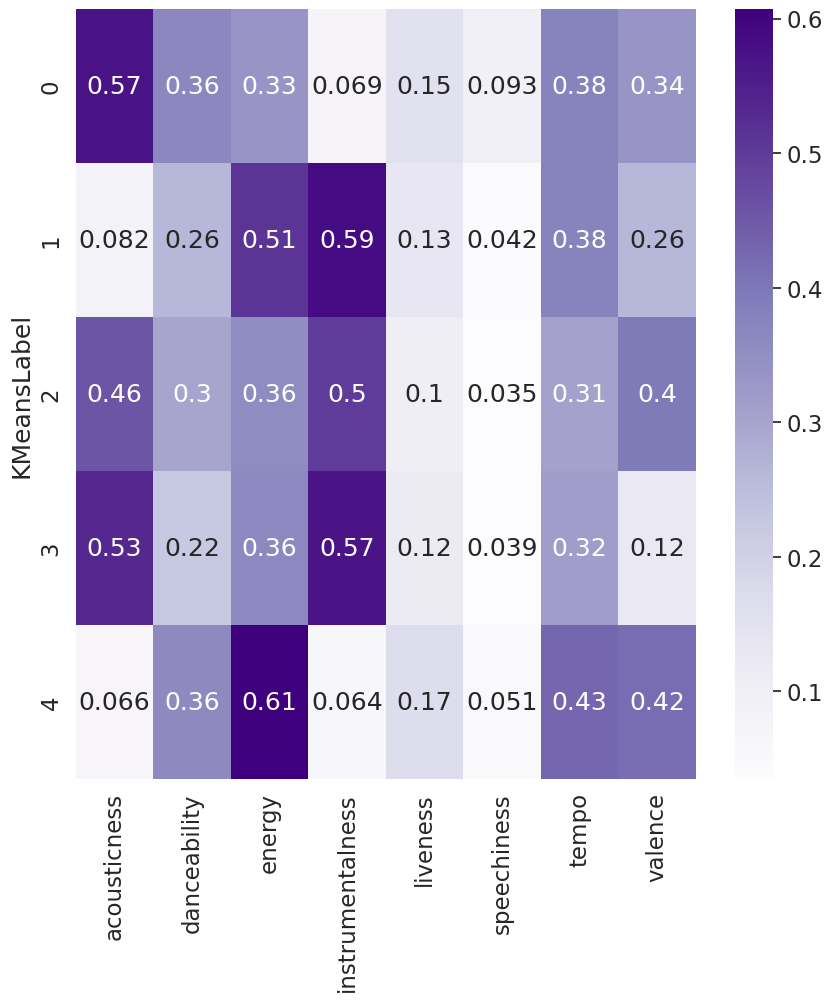

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(
    data=clusters_rock.loc[clusters_rock.method=='KMeans', audio_cols],
    cmap='Purples',
    annot=True
)
plt.ylabel("KMeansLabel")
plt.savefig("KM{}_heatmap.png".format(k))

- **KM0**: High Energy, Valence, Tempo, Danceablity. Low acousticness, instrumentalness. Probably just described Pop. "Upbeat Rock with Synths to Dance to"
- **KM1**: High Acousticness and Instrumentalness. Not Danceable. Low Speechiness, Tempo, and Valence. "Slow & Depressing Rock"
- **KM2**: High Acousticness, Instrumentalness and Valence. Lowest Speechiness and Tempo. "Slow & Cheerful Rock"
- **KM3**: High Acousticness and Danceability. Low Energy. "Slow Dance Rock"
- **KM4**: High Instrumentalness, Tempo and Energy. Low Acousticness, Danceability. "Fast & Energetic Rock"

In [ ]:
rock_tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genres_all,subgenre,KMeansLabel,SpectralClusteringKnownLabel,SpectralClusteringUnknownLabel,MeanShiftLabel,WardLabel
track_id,,,,,,,,,,,,,,,
153,0.564283,0.145972,0.559412,0.555548,0.069281,0.029541,0.180698,0.019423,"[Post-Rock, Rock]",Rock,3,3,6,0,4
154,0.683635,0.248714,0.016808,0.674459,0.079813,0.022674,0.089958,0.025109,"[Post-Rock, Rock]",Rock,3,3,4,0,2
155,0.566930,0.082152,0.526772,0.558635,0.209935,0.050549,0.187770,0.019824,"[Post-Rock, Rock]",Rock,3,3,6,0,4
169,0.748292,0.170953,0.546829,0.199019,0.069879,0.040402,0.255398,0.021445,"[Punk, Rock]",Punk,3,0,5,0,3
170,0.567977,0.191225,0.476805,0.589943,0.089417,0.056871,0.228058,0.047113,"[Punk, Rock]",Punk,3,3,6,0,4


In [ ]:
#distances = [abs(np.linalg.norm(genre_coordinates-c)) for c in genre_coordinates_other]
### Assign K-Means Label to Descriptive Labels
descriptive_labels = ["Upbeat Rock with Synths to Dance to", "Slow & Depressing Rock", "Slow & Cheerful Rock",
                     "Slow Dance Rock", "Fast & Energetic Rock"]
unique_labels = np.unique(rock_tracks["KMeansLabel"].values)
translated_labels = dict(zip(unique_labels, descriptive_labels))
rock_tracks['KMeansLabel'] = list(map(lambda x:translated_labels[x], (rock_tracks["KMeansLabel"].values)))

genre_count = rock_tracks.groupby('subgenre').agg({'subgenre':'count'})['subgenre']

# How many instances of each subgenre of rock are there?
print("### Instances of subgenre ###")
print(rock_tracks[['subgenre', 'KMeansLabel']].groupby('subgenre').agg('count'))

# How many instances of each k-means cluster are there?
print("### Instances of KMeans Cluster ###")
print(rock_tracks[['subgenre', 'KMeansLabel']].groupby('KMeansLabel').agg('count'))

# Which cluster corresponds to the most instances per genre?
print("### Which cluster corresponds to the most instances per genre? ###")
print(rock_tracks[['subgenre', 'KMeansLabel']].groupby('subgenre').agg(lambda x:x.value_counts().index[0]))

# Which genre corresponds to the most instances per cluster?
print("### Which genre corresponds to the most instances per cluster? ###")
print(rock_tracks[['subgenre', 'KMeansLabel']].groupby('KMeansLabel').agg(lambda x:x.value_counts().index[0]))

### Instances of subgenre ###
            KMeansLabel
subgenre               
Indie-Rock          730
Pop                 400
Psych-Rock          447
Punk               1474
Rock               1790
### Instances of KMeans Cluster ###
                                     subgenre
KMeansLabel                                  
Fast & Energetic Rock                     735
Slow & Cheerful Rock                     1101
Slow & Depressing Rock                   1314
Slow Dance Rock                          1156
Upbeat Rock with Synths to Dance to       535
### Which cluster corresponds to the most instances per genre? ###
                       KMeansLabel
subgenre                          
Indie-Rock    Slow & Cheerful Rock
Pop         Slow & Depressing Rock
Psych-Rock         Slow Dance Rock
Punk        Slow & Depressing Rock
Rock        Slow & Depressing Rock
### Which genre corresponds to the most instances per cluster? ###
                                    subgenre
KMeansLabel         

#### Interpretation

Again, some interesting and intuitive conclusions can be made from the cluster groupings.

In cell 2, Psych-Rock mostly fell under the Slow & Depressing Rock cluster which is on point. Punk tends to be fast & energetic subset of rock as well, but Pop and "Plain" Rock also fall under the same cluster. Indie Rock does tend to be slower, but is differentiated by Psych Rock with its mood.

In cell 3, we see that 4 out of 5 KMeans Labels are dominated by Rock. This is partially due to the imbalanced sampling of plain Rock, which takes up over a third of the dataset. Fast & Energetic Rock is dominated by Punk, matching the intuition behind the typical features of punk

### Evaluation

Just as above, PCA is performed on rock_tracks to reduce dimensionality and allow for the dataset to be visualized. Then some clustering metrics are calculated based on the estimated "ground truth" that the subgenres represent real clusters in the data. 

In [ ]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_
x,y = zip(*X_new)
rock_tracks['x'] = x
rock_tracks['y'] = y
audio_components_rock = dict(list(zip(audio_cols, zip(*np.round(components,2)))))
audio_components_rock


{'acousticness': (0.68, 0.54),
 'danceability': (-0.1, 0.21),
 'energy': (-0.42, -0.23),
 'instrumentalness': (0.5, -0.74),
 'liveness': (-0.06, 0.02),
 'speechiness': (-0.01, 0.05),
 'tempo': (-0.16, -0.01),
 'valence': (-0.28, 0.27)}

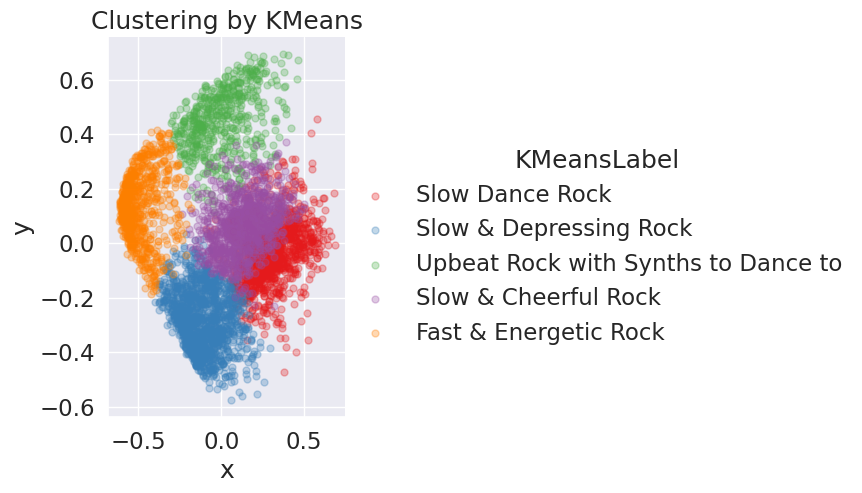

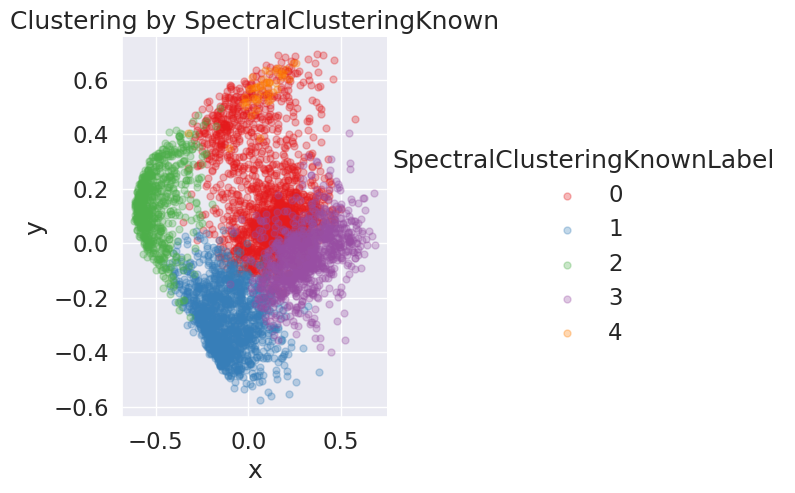

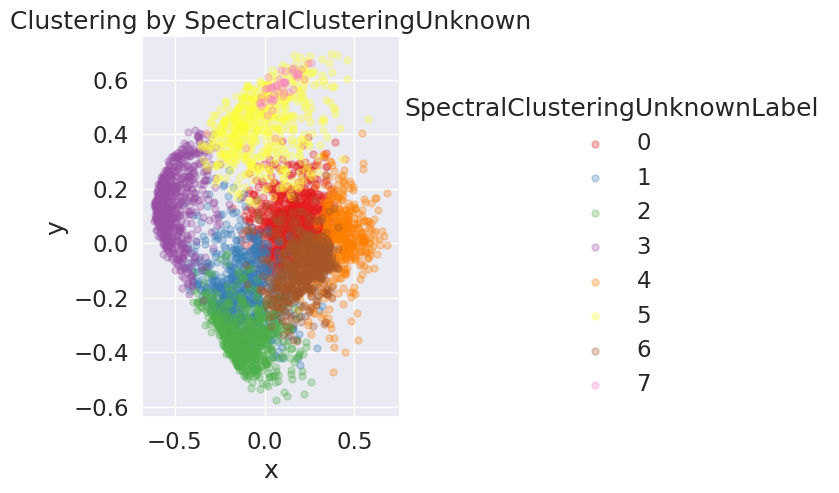

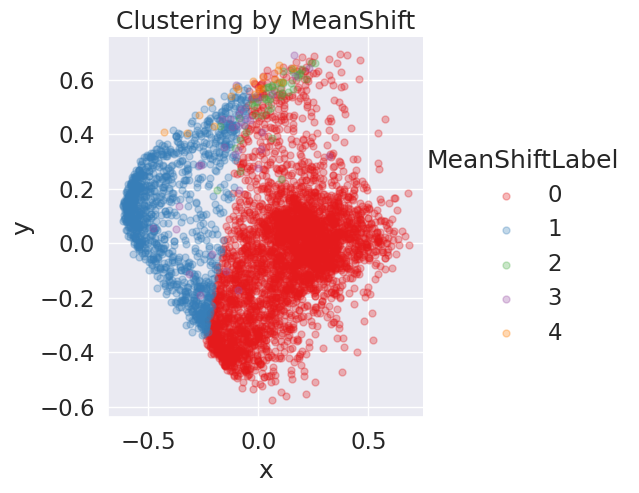

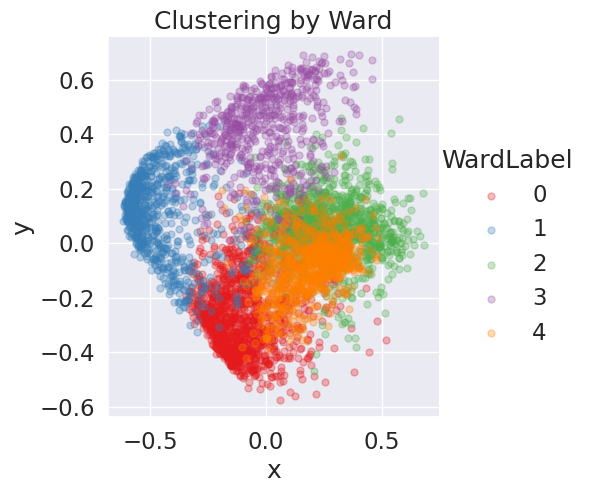

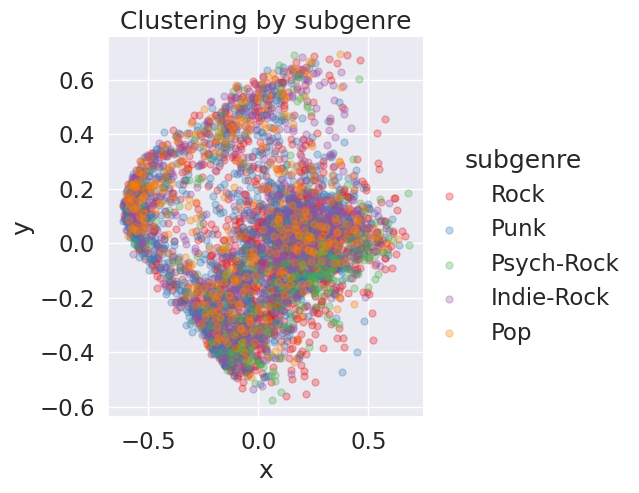

In [ ]:
y_label_cols = [name+"Label" for name in clustering_algorithm_names]
y_label_cols.append('subgenre')
for y_label_col in y_label_cols:
    sns.set(font_scale=1.5)
    sns.lmplot(data=rock_tracks, x='x', y='y', hue=y_label_col, fit_reg=False, legend=True, palette='Set1',
               scatter_kws={'alpha':0.3, 's':25})
    if y_label_col == 'subgenre':
        plt.title("Clustering by {}".format(y_label_col))
    else:
        plt.title("Clustering by {}".format(y_label_col.replace("Label", "")))
    plt.savefig("{}Clustering{}Clusters.png".format(y_label_col.replace("Label",""),k))

In [ ]:
for y_label in clustering_algorithm_names:
    y_label_col = y_label + "Label"
    y_true = rock_tracks['subgenre']
    y_pred = rock_tracks[y_label_col]
    metrics = {'adjusted_rand_score': adjusted_rand_score, 
               'adjusted_mutual_info_score': adjusted_mutual_info_score, 
               'v_measure_score': v_measure_score, 
              }
    scores = dict(zip(metrics.keys(), [metrics[m](y_true, y_pred) for m in metrics.keys()]))
    scores['silhouette_score'] = silhouette_score(X,y_pred)
    
    print("###### {} Clustering #####".format(y_label))
    for k,v in scores.items():
        print("Metric: {} Score: {}".format(k, v))
    print("\n")
    

###### KMeans Clustering #####
Metric: adjusted_rand_score Score: 0.008618827653904768
Metric: adjusted_mutual_info_score Score: 0.011309423829577179
Metric: v_measure_score Score: 0.012399558177445513
Metric: silhouette_score Score: 0.24060793820996285


###### SpectralClusteringKnown Clustering #####
Metric: adjusted_rand_score Score: 0.0059782591680770545
Metric: adjusted_mutual_info_score Score: 0.011203593290525851
Metric: v_measure_score Score: 0.012372533902620369
Metric: silhouette_score Score: 0.21921187013736518


###### SpectralClusteringUnknown Clustering #####
Metric: adjusted_rand_score Score: 0.008827264586282548
Metric: adjusted_mutual_info_score Score: 0.015410656624509772
Metric: v_measure_score Score: 0.01710156714827816
Metric: silhouette_score Score: 0.21117565215153936


###### MeanShift Clustering #####
Metric: adjusted_rand_score Score: 0.008041549071362196
Metric: adjusted_mutual_info_score Score: 0.008274406600825257
Metric: v_measure_score Score: 0.0099153315

#### Other Clustering Algorithms and their clusters

In [ ]:
for y_label in clustering_algorithm_names:
    y_label_col = y_label + "Label"

    genre_count = tracks.groupby('genre_top').agg({'genre_top':'count'})['genre_top']

    # How many instances of each cluster are there?
    print(rock_tracks[['subgenre', y_label_col]].groupby(y_label_col).agg('count'))

    # Which cluster corresponds to the most instances per genre?
    print(rock_tracks[['subgenre', y_label_col]].groupby('subgenre').agg(lambda x:x.value_counts().index[0]))

    # Which genre corresponds to the most instances per cluster?
    print(rock_tracks[['subgenre', y_label_col]].groupby(y_label_col).agg(lambda x:x.value_counts().index[0]))

                                     subgenre
KMeansLabel                                  
Fast & Energetic Rock                     735
Slow & Cheerful Rock                     1101
Slow & Depressing Rock                   1314
Slow Dance Rock                          1156
Upbeat Rock with Synths to Dance to       535
                       KMeansLabel
subgenre                          
Indie-Rock    Slow & Cheerful Rock
Pop         Slow & Depressing Rock
Psych-Rock         Slow Dance Rock
Punk        Slow & Depressing Rock
Rock        Slow & Depressing Rock
                                    subgenre
KMeansLabel                                 
Fast & Energetic Rock                   Punk
Slow & Cheerful Rock                    Rock
Slow & Depressing Rock                  Rock
Slow Dance Rock                         Rock
Upbeat Rock with Synths to Dance to     Rock
                              subgenre
SpectralClusteringKnownLabel          
0                                 1679
1

#### K = 7

In [ ]:
### Accumulate top subgenres

genres_dict = {}
rock_tracks['genres_all'].apply(lambda row:count_genres(row,genres_dict))
k=7
genres_by_count = pd.Series(genres_dict).sort_values(ascending=False)
print("Top 10 instances of subgenres within rock tracks")
print(genres_by_count[:10])

# Starting at 1 to exclude "Rock", which is a main genre and applies to all rock tracks
top_subgenres = genres_by_count[1:k]
top_subgenres_list = list(top_subgenres.index.values)

### Assign subgenres for those containing more than one genre
rock_tracks['subgenre'] = list(map(lambda row: assign_subgenre(row, top_subgenres_list, "Rock"), rock_tracks['genres_all']))
print("Rock tracks reduced to a top {} subgenre".format(k))
print(rock_tracks['subgenre'].value_counts())


subgenre_groupby = rock_tracks.copy().groupby('subgenre').agg('mean')
clusters_rock = subgenre_groupby.reset_index().rename({'subgenre':'cluster'}, axis=1)
clusters_rock['method'] = 'AggMean'


params = {'quantile': .14,
        'n_clusters': k
}
params['bandwidth'] = estimate_bandwidth(X,quantile=params['quantile'])
# ============
# Create cluster objects
# ============
km = KMeans(n_clusters=params['n_clusters'], random_state=1986)
ward = AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
)
spectral_known = SpectralClustering(
    n_clusters=params['n_clusters'], 
    affinity="nearest_neighbors")



clustering_algorithms = (
    ('KMeans', km),
    ('SpectralClusteringKnown', spectral_known),
    ('Ward', ward),
)
clustering_algorithm_names = ['KMeans', 
                              'SpectralClusteringKnown', 
                              'Ward']
for name, algorithm in clustering_algorithms:

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
        
    ### Store cluster centers
    
    if hasattr(algorithm, 'cluster_centers_'):
        cluster_centers = algorithm.cluster_centers_
        labels_unique = np.unique(y_pred)
        n_clusters_ = len(labels_unique)
        algo_clusters = pd.DataFrame(cluster_centers, columns=audio_cols)
        algo_clusters['cluster'] = ['{}{}'.format(name,l+1) for l in labels_unique]
        algo_clusters['method'] = name
        clusters_rock = pd.concat([clusters_rock, algo_clusters])
    ### SpectralClustering doesn't have cluster centers
    elif hasattr(algorithm, 'affinity_matrix_'):
        affinity_matrix = algorithm.affinity_matrix_
        
    ### Store labels to rock_tracks
    new_col = '{}Label{}Clusters'.format(name,k)
    rock_tracks[new_col] = y_pred

    #plt.subplot(1, len(clustering_algorithms), plot_num)
    


Top 10 instances of subgenres within rock tracks
Rock          4798
Punk          1551
Indie-Rock    1011
Psych-Rock     542
Pop            533
Post-Punk      382
Metal          256
Post-Rock      209
Hardcore       208
Power-Pop      199
dtype: int64
Rock tracks reduced to a top 7 subgenre
Rock          1598
Punk          1132
Indie-Rock     714
Psych-Rock     438
Pop            397
Post-Punk      370
Metal          192
Name: subgenre, dtype: int64


<ipython-input-57-4d33fbe613c1>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subgenre_groupby = rock_tracks.copy().groupby('subgenre').agg('mean')
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-57-4d33fbe613c1>:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Num

In [ ]:
rock_tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genres_all,subgenre,KMeansLabel,SpectralClusteringKnownLabel,SpectralClusteringUnknownLabel,MeanShiftLabel,WardLabel,x,y,KMeansLabel7Clusters,SpectralClusteringKnownLabel7Clusters,WardLabel7Clusters
track_id,,,,,,,,,,,,,,,,,,,,
153,0.564283,0.145972,0.559412,0.555548,0.069281,0.029541,0.180698,0.019423,"[Post-Rock, Rock]",Rock,Slow Dance Rock,3,6,0,4,0.294946,-0.097483,5,5,4
154,0.683635,0.248714,0.016808,0.674459,0.079813,0.022674,0.089958,0.025109,"[Post-Rock, Rock]",Rock,Slow Dance Rock,3,4,0,2,0.664330,0.027810,0,2,3
155,0.566930,0.082152,0.526772,0.558635,0.209935,0.050549,0.187770,0.019824,"[Post-Rock, Rock]",Rock,Slow Dance Rock,3,6,0,4,0.308399,-0.100328,5,5,4
169,0.748292,0.170953,0.546829,0.199019,0.069879,0.040402,0.255398,0.021445,"[Punk, Rock]",Punk,Slow Dance Rock,0,5,0,3,0.232746,0.272145,5,6,1
170,0.567977,0.191225,0.476805,0.589943,0.089417,0.056871,0.228058,0.047113,"[Punk, Rock]",Punk,Slow Dance Rock,3,6,0,4,0.327947,-0.083823,5,5,4


In [ ]:
clustering_algorithm_names

['KMeans', 'SpectralClusteringKnown', 'Ward']

In [ ]:
pd.DataFrame(cluster_centers,columns=audio_cols)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,0.573318,0.291240,0.198115,0.593892,0.109305,0.038093,0.292184,0.156401
1,0.474090,0.284862,0.368887,0.487783,0.104362,0.032835,0.306797,0.403972
2,0.071750,0.231434,0.539011,0.608288,0.141741,0.045790,0.391065,0.169960
3,0.064038,0.359146,0.610782,0.054149,0.168170,0.051848,0.429226,0.414637
4,0.572265,0.368020,0.332547,0.060113,0.151211,0.094439,0.376812,0.338370
5,0.482774,0.190580,0.486520,0.538303,0.123570,0.042325,0.335207,0.141518
6,0.108768,0.328495,0.448262,0.533331,0.114499,0.034509,0.347015,0.435254


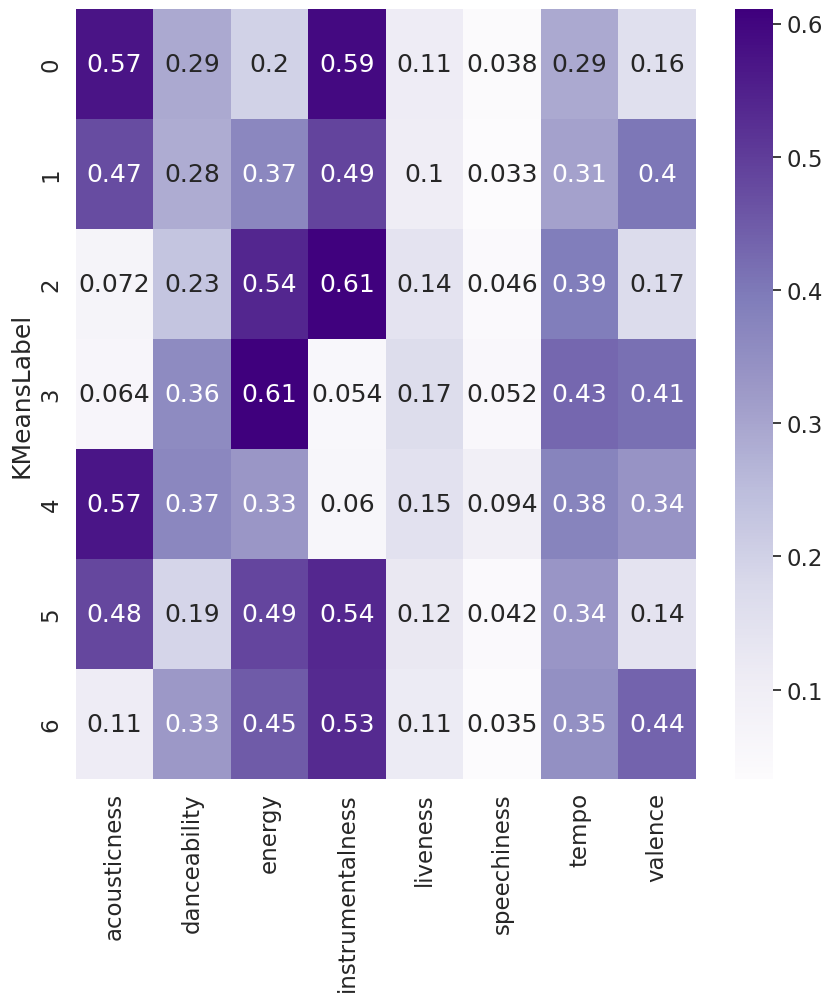

In [ ]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_
x,y = zip(*X_new)
rock_tracks['x'] = x
rock_tracks['y'] = y
audio_components_rock = dict(list(zip(audio_cols, zip(*np.round(components,2)))))

sns.set(font_scale=1.5)
plt.figure(figsize=(10,10))
sns.heatmap(
    data=clusters_rock.loc[clusters_rock.method=='KMeans', audio_cols],
    cmap='Purples',
    annot=True
)
plt.ylabel("KMeansLabel")
plt.savefig('heatmap_rock.png')

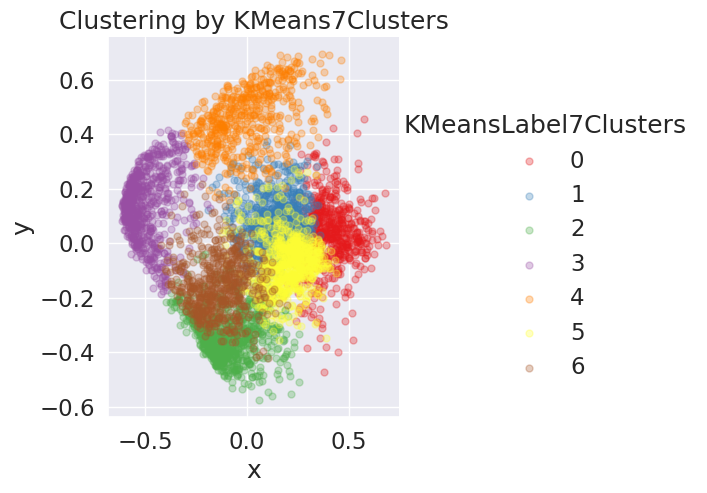

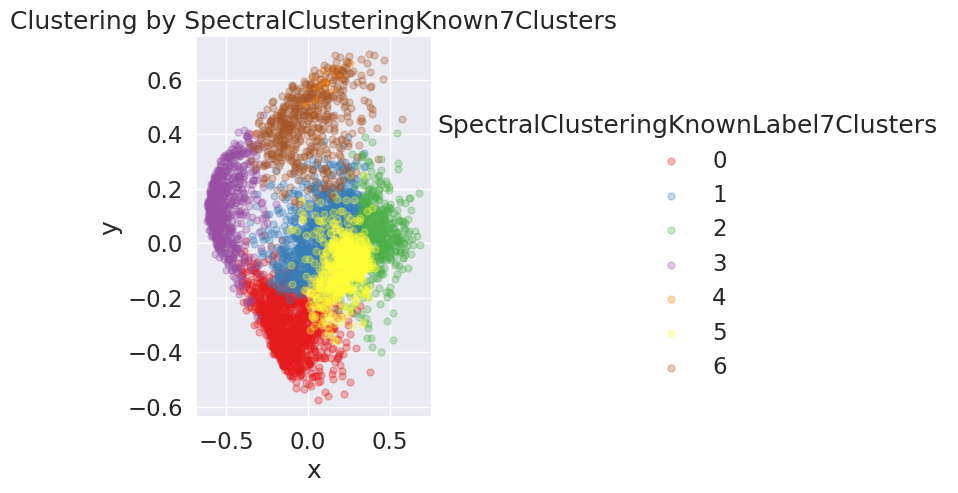

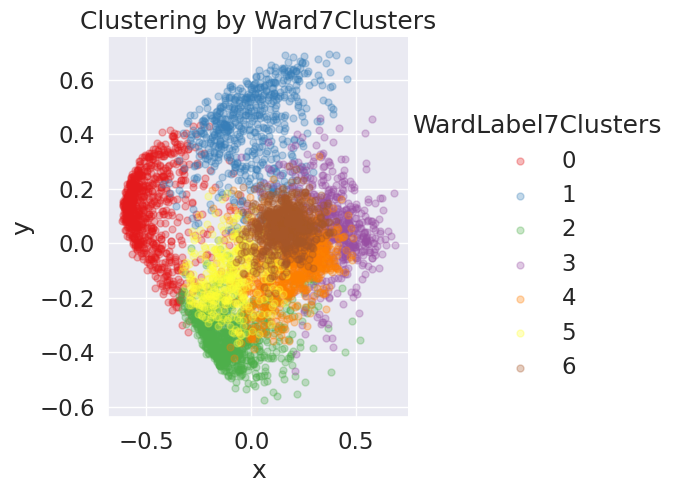

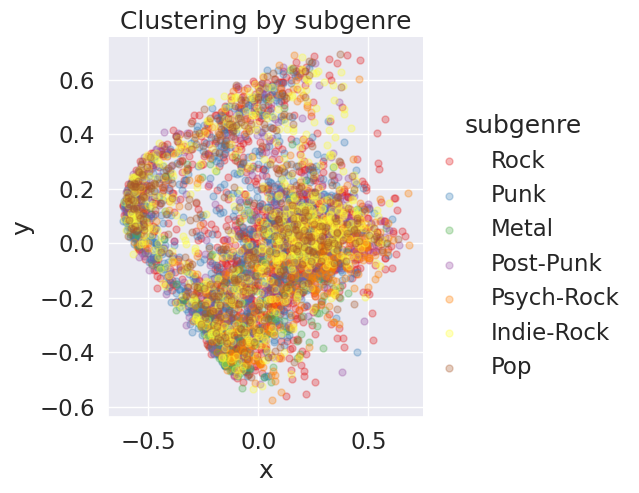

In [ ]:
y_label_cols = [name+"Label7Clusters" for name in clustering_algorithm_names]
y_label_cols.append('subgenre')
for y_label_col in y_label_cols:
    sns.lmplot(data=rock_tracks, x='x', y='y', hue=y_label_col, fit_reg=False, legend=True, palette='Set1',
               scatter_kws={'alpha':0.3, 's':25})
    if y_label_col == 'subgenre':
        plt.title("Clustering by {}".format(y_label_col))
    else:
        plt.title("Clustering by {}".format(y_label_col.replace("Label", "")))
    plt.savefig("{}Clustering{}Clusters.png".format(y_label_col.replace("Label",""),k))

In [ ]:
for y_label in clustering_algorithm_names:
    y_label_col = y_label + "Label{}Clusters".format(k)

    genre_count = tracks.groupby('genre_top').agg({'genre_top':'count'})['genre_top']

    print("### How many instances of each cluster are there? ###")
    print(rock_tracks[['subgenre', y_label_col]].groupby(y_label_col).agg('count'))

    print("### Which cluster corresponds to the most instances per genre? ###")
    print(rock_tracks[['subgenre', y_label_col]].groupby('subgenre').agg(lambda x:x.value_counts().index[0]))

    # Which genre corresponds to the most instances per cluster?
    print("### Which genre corresponds to the most instances per cluster? ###")
    print(rock_tracks[['subgenre', y_label_col]].groupby(y_label_col).agg(lambda x:x.value_counts().index[0]))
    
    # Breakdown
#     values = rock_tracks.KMeansLabel7Clusters.value_counts().keys().tolist()
#     counts = rock_tracks.KMeansLabel7Clusters.value_counts().tolist()
#     print(list(zip(values,counts)))

### How many instances of each cluster are there? ###
                      subgenre
KMeansLabel7Clusters          
0                          616
1                          846
2                          801
3                          707
4                          515
5                          752
6                          604
### Which cluster corresponds to the most instances per genre? ###
            KMeansLabel7Clusters
subgenre                        
Indie-Rock                     1
Metal                          2
Pop                            3
Post-Punk                      1
Psych-Rock                     5
Punk                           1
Rock                           1
### Which genre corresponds to the most instances per cluster? ###
                     subgenre
KMeansLabel7Clusters         
0                        Rock
1                        Rock
2                        Rock
3                        Punk
4                        Rock
5                        R

#### Elbow Method for KMeans

In [ ]:
Ks = np.arange(1, 20)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(X).score(X) for i in range(len(km))]
Ks.dtype = int


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(0.5, 0, 'K')

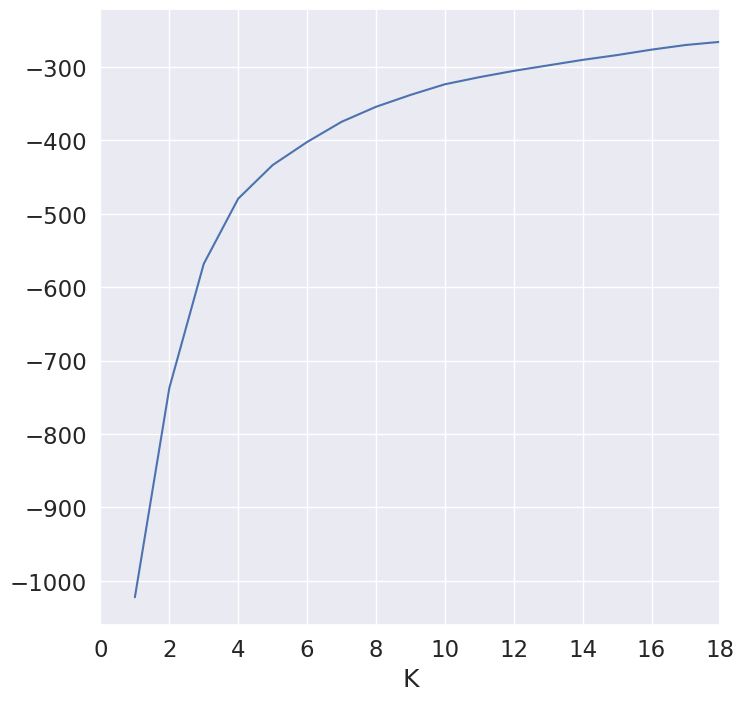

In [ ]:

plt.figure(figsize=(8,8))
plt.plot(Ks,score)
plt.xlim(0,18)
plt.grid(True)
plt.xlabel('K')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(0.5, 0, 'K')

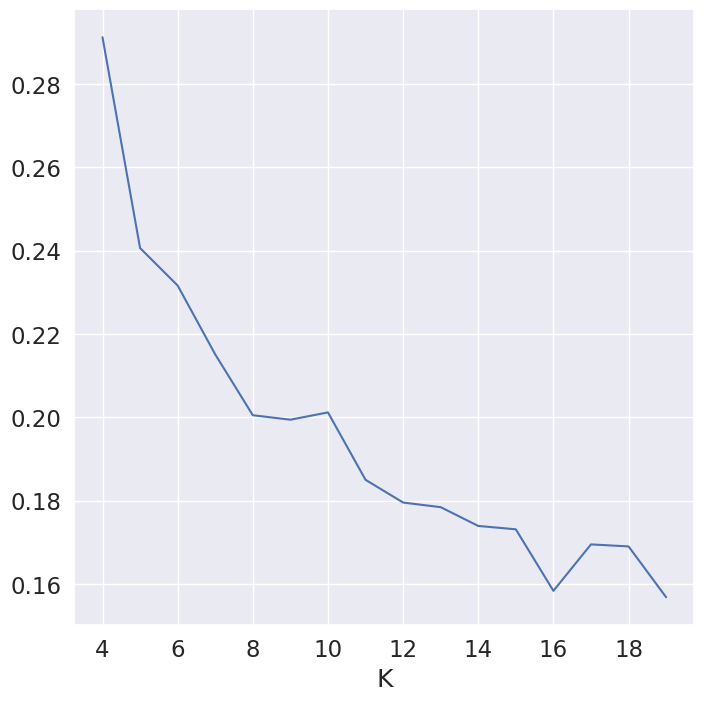

In [ ]:
Ks = np.arange(2, 20)
kms = [KMeans(n_clusters=i, random_state=1986).fit(X) for i in Ks]
s_scores = [silhouette_score(X,kms[i].labels_) for i in range(2,len(Ks))]
plt.figure(figsize=(8,8))
plt.plot(Ks[2:len(Ks)],s_scores)
#plt.xlim(0,18)
plt.grid(True)
plt.xlabel('K')
            

## III. Conclusion
### Genre Clustering Shows Structure Differently Than Genres Themselves
Due to the subjective nature of clustering, and the variable nature of music, it's difficult to decisively grade the model's performance. Various clustering algorithms were able to find structure, just not the same messy structure that is estimated by our subjective listening experience. However, this makes for interesting cross-genre similarities. A user who listens to mostly, say Classical, may discover Folk/Blues songs he/she likes that otherwise wouldn't be discovered if music recommendation engines drew the line within boundaries.  Where songs are divided into genres, audio feature groupings tend to cross. 

### Intuitive Pairings
The clusters from the features do suggest interesting and intuitive relationships between genres. A punk fan will agree that punk tends to be fast and energetic, and a psych-rock fan will agree that psych-rock is slow and depressing.

### Future Work
The main constraints of this analysis are the following:
- usage of a relatively small (13000 tracks) and limited dataset. Perhaps using Spotify's API to gather more music data would allow the data to build a semblance of structure. 
- Spotify's features constrained the music to be described in 8 different ways. Maybe using more descriptive features as the ones used could illuminate some of the key distinctions between genres. 